* `Import Libraries`

In [31]:
import numpy as np 
import pandas as pd 
import joblib 
import wordcloud
import os 
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import nltk
import spacy
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

* `Read The Dataset`

In [2]:
FILE_PATH = os.path.join(os.getcwd(),"test.csv") 
df = pd.read_csv(FILE_PATH) 
df.head()


Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. Company Wins Grant to Study Peptides (AP)   
3            4      Prediction Unit Helps Forecast Wildfires (AP)   
4            4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                         Description  
0  Unions representing workers at Turner   Newall...  
1  SPACE.com - TORONTO, Canada -- A second\team o...  
2  AP - A company founded by a chemistry research...  
3  AP - It's barely dawn when Mike Fitzpatrick st...  
4  AP - Southern California's smog-fighting agenc...

* `EDA`

In [3]:
df.shape

(7600, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [5]:
df['text'] = df['Title'] + ' ' + df['Description'] 
df = df.drop(['Title', 'Description'], axis=1)


In [6]:
df.describe()

Class Index
count  7600.000000
mean      2.500000
std       1.118108
min       1.000000
25%       1.750000
50%       2.500000
75%       3.250000
max       4.000000

In [7]:
df['Class Index'].value_counts()

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

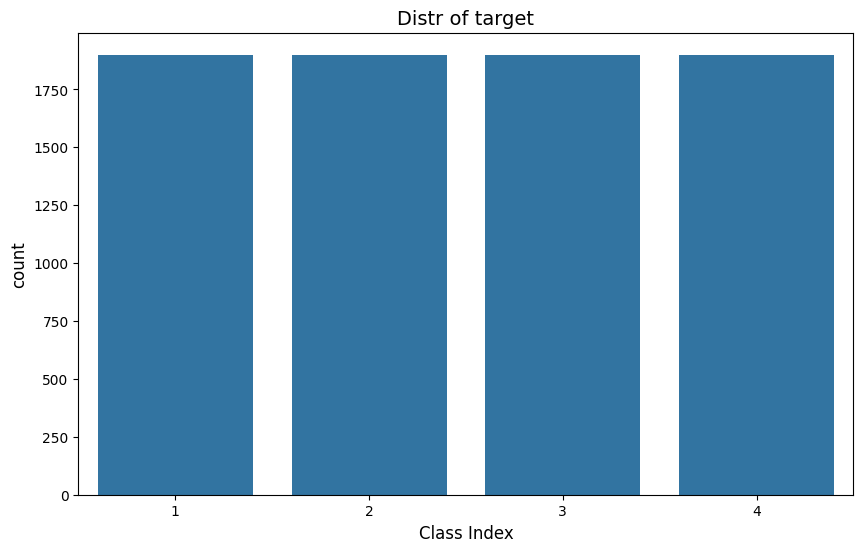

In [8]:
plt.figure(figsize=(10,6)) 
sns.countplot(data=df,x='Class Index') 
plt.title('Distr of target',fontsize=14,c='k') 
plt.xlabel('Class Index',c='k',fontsize=12) 
plt.ylabel('count',c='k',fontsize=12)
plt.show()

* `Text Cleaning & Vizualization`

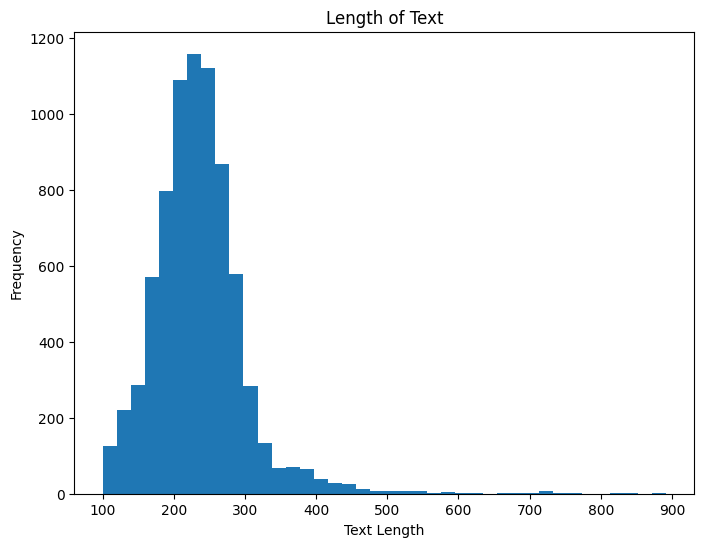

In [9]:
# Sequence Length
length_review = df['text'].str.len()
plt.figure(figsize=(8, 6))
plt.hist(length_review, bins=40)
plt.title('Length of Text')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Remove unwanted text patterns from the review
def remove_pattern(input_text,pattern):
    return re.sub(pattern,' ',input_text)

#### `Remove Repeated Characters`

In [11]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
df.loc[:, 'text'] = df['text'].apply(remove_excessive_repeated_characters)
df.head()

Class Index                                               text
0            3  Fears for T N pension after talks Unions repre...
1            4  The Race is On: Second Private Team Sets Launc...
2            4  Ky. Company Wins Grant to Study Peptides (AP) ...
3            4  Prediction Unit Helps Forecast Wildfires (AP) ...
4            4  Calif. Aims to Limit Farm-Related Smog (AP) AP...

* `Remove Punctuation, Numbers, Special Chars`

In [12]:
# Remove special characters and digits and Convert to lowercase
df['text'] = df['text'].str.lower()
df.loc[:,'text'] = df['text'].apply(lambda x :remove_pattern(x,r'[^a-zA-Z\s]'))
df.loc[:,'text'] = df['text'].str.replace('\s+', ' ',regex=True)
df.head()

Class Index                                               text
0            3  fears for t n pension after talks unions repre...
1            4  the race is on second private team sets launch...
2            4  ky company wins grant to study peptides ap ap ...
3            4  prediction unit helps forecast wildfires ap ap...
4            4  calif aims to limit farm related smog ap ap so...

* `Removing short words`

In [13]:
df.loc[:, 'text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

Class Index                                               text
0            3  fears pension after talks unions representing ...
1            4  race second private team sets launch date huma...
2            4  company wins grant study peptides company foun...
3            4  prediction unit helps forecast wildfires barel...
4            4  calif aims limit farm related smog southern ca...

* `Remove Numbers from Words`

In [14]:
df.loc[:, 'text'] = df['text'].apply(lambda x: remove_pattern(x, '(?<=\w)\d+|\d+(?=\w)'))
df.head()

Class Index                                               text
0            3  fears pension after talks unions representing ...
1            4  race second private team sets launch date huma...
2            4  company wins grant study peptides company foun...
3            4  prediction unit helps forecast wildfires barel...
4            4  calif aims limit farm related smog southern ca...

* `Remove Special Chars`

In [15]:
df.loc[:, 'text'] = df['text'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
df.head()

Class Index                                               text
0            3  fears pension after talks unions representing ...
1            4  race second private team sets launch date huma...
2            4  company wins grant study peptides company foun...
3            4  prediction unit helps forecast wildfires barel...
4            4  calif aims limit farm related smog southern ca...

* `Rmeove Redundant words`

In [16]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
df.loc[:, 'text'] = df['text'].apply(remove_redundant_words_extra_spaces)
df.head()

Class Index                                               text
0            3  fears pension talks unions representing worker...
1            4  race second private team sets launch date huma...
2            4  company wins grant study peptides company foun...
3            4  prediction unit helps forecast wildfires barel...
4            4  calif aims limit farm related smog southern ca...

In [17]:
# Create a folder for cleaned dataset
Cleaned_Dataset = os.path.join(os.getcwd(),'clean_dataset') 
os.makedirs(Cleaned_Dataset,exist_ok=True) 

In [18]:
# Download the dataset here at this step before Lemmatizing
df.to_csv(os.path.join(Cleaned_Dataset, "clean_dataset_2.csv"), index=False)

* `Tokenization`

In [19]:
tokenize_text = df['text'].apply(lambda x : word_tokenize(x)) 
tokenize_text.head()

0    [fears, pension, talks, unions, representing, ...
1    [race, second, private, team, sets, launch, da...
2    [company, wins, grant, study, peptides, compan...
3    [prediction, unit, helps, forecast, wildfires,...
4    [calif, aims, limit, farm, related, smog, sout...
Name: text, dtype: object

In [20]:
lemmatizer = WordNetLemmatizer() 
tokenize_text= tokenize_text.apply(lambda x:[lemmatizer.lemmatize(i) for i in x]) 
tokenize_text

0       [fear, pension, talk, union, representing, wor...
1       [race, second, private, team, set, launch, dat...
2       [company, win, grant, study, peptide, company,...
3       [prediction, unit, help, forecast, wildfire, b...
4       [calif, aim, limit, farm, related, smog, south...
                              ...                        
7595    [around, world, ukrainian, presidential, candi...
7596    [void, filled, clement, supply, attractive, pi...
7597    [martinez, leaf, bitter, like, roger, clemens,...
7598    [arthritis, patient, singapore, take, bextra, ...
7599    [ebay, get, rental, ebay, plan, apartment, hom...
Name: text, Length: 7600, dtype: object

In [21]:
df.loc[:,'text'] = tokenize_text.apply(lambda x : ' '.join(x)) 
df.head()

Class Index                                               text
0            3  fear pension talk union representing worker tu...
1            4  race second private team set launch date human...
2            4  company win grant study peptide company founde...
3            4  prediction unit help forecast wildfire barely ...
4            4  calif aim limit farm related smog southern cal...

In [22]:
os.path.join(Cleaned_Dataset,'clean_dataset_2.csv')

'c:\\Users\\Abdallah Samir\\Desktop\\ELEVVO\\src\\notebooks\\clean_dataset\\clean_dataset_2.csv'

* `Bonus`

* `Some Viz with Wordcloud`

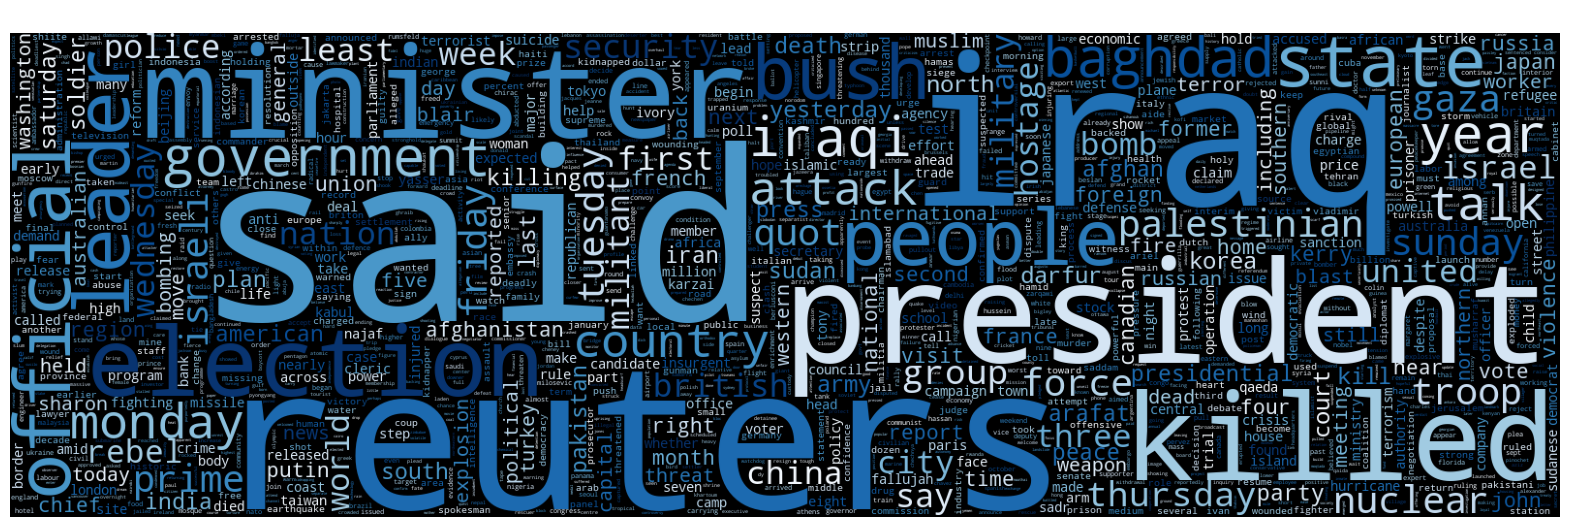

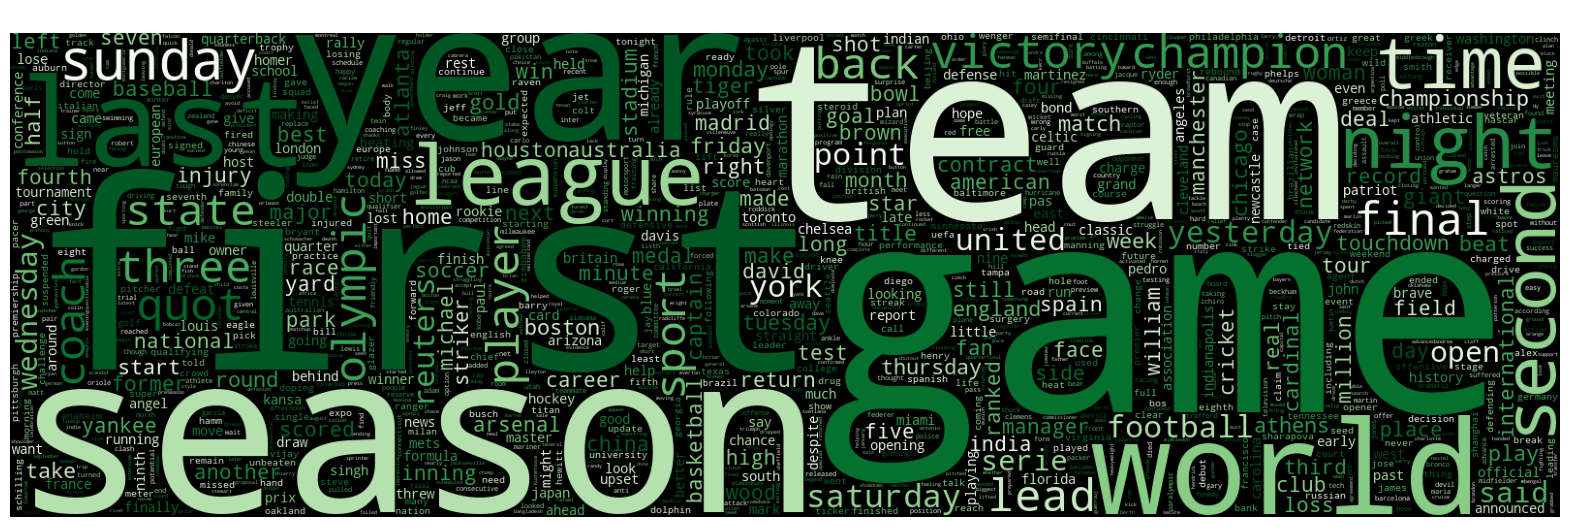

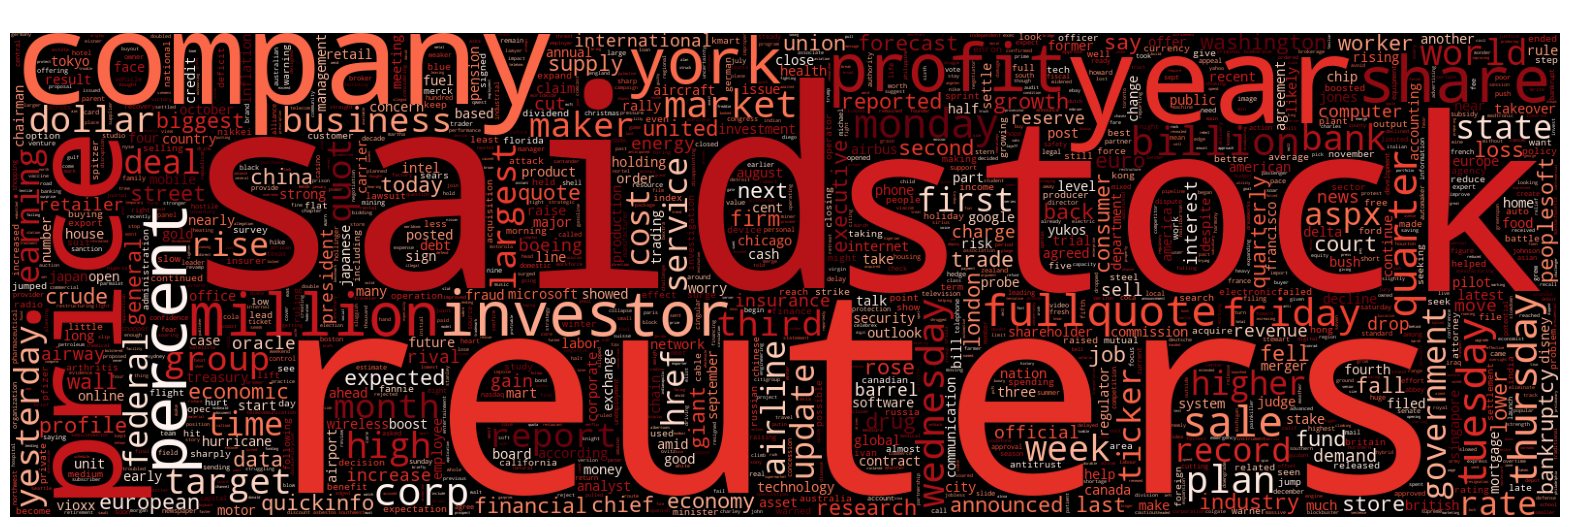

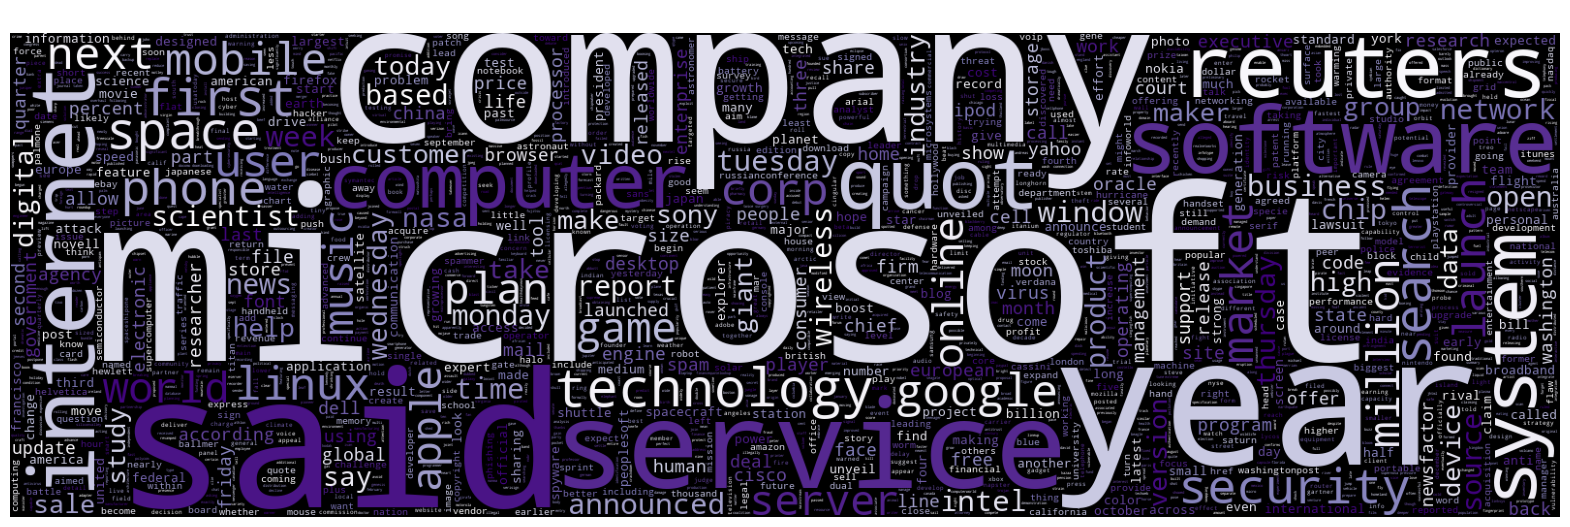

In [23]:
classes = [1, 2, 3, 4]
colors = ['Blues', 'Greens', 'Reds', 'Purples']
class_names = ['World', 'Sports', 'Business', 'Sci/Tech'] 

for i, class_idx in enumerate(classes):
    category_df = df[df['Class Index'] == class_idx]
    
    plt.figure(figsize=(20, 8))
    wc = WordCloud(max_words=10000, width=1600, height=500,
                   background_color='black', collocations=False,
                   colormap=colors[i]).generate(' '.join(category_df['text'].astype(str)))
    plt.title(f'Class {class_idx} ({class_names[i]}) News Visualization', fontsize=14, c='white')
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

* ` Text Vectorization`

* `2. TF-IDF` 

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
X = X_tfidf
y = df['Class Index']

* `Split the data`

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.2,random_state=45,shuffle=True)

* `Building Models`

* `LogisticRegression`

In [37]:
log_clf = LogisticRegression(C=1.5,max_iter=1000,random_state=45,solver='liblinear')
log_clf.fit(X_train,y_train )

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train)
y_pred_test_log = log_clf.predict(X_test)

# Using f1_score
score_train_log = accuracy_score(y_train, y_pred_train_log)
score_test_log = accuracy_score(y_test, y_pred_test_log)

print(f'The accuracy_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The accuracy_score using Logistic model for Testing Dataset  is {score_test_log*100:.3f}')

The accuracy_score using Logistic model for Training Dataset is 94.375
The accuracy_score using Logistic model for Testing Dataset  is 86.645


 * `XGBoost`

In [43]:
# Create and train XGBoost classifier
y_train_fixed = y_train - 1
y_test_fixed = y_test - 1

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,      
    max_depth=6,          
    learning_rate=0.1,    
    random_state=45
)


xgb_clf.fit(X_train, y_train_fixed)


y_pred_train_xgb = xgb_clf.predict(X_train)
y_pred_test_xgb = xgb_clf.predict(X_test)


y_pred_train_original = y_pred_train_xgb + 1
y_pred_test_original = y_pred_test_xgb + 1


score_train_xgb = accuracy_score(y_train, y_pred_train_original)
score_test_xgb = accuracy_score(y_test, y_pred_test_original)

print(f'The accuracy_score using XGBoost model for Training Dataset is {score_train_xgb*100:.3f}%')
print(f'The accuracy_score using XGBoost model for Testing Dataset is {score_test_xgb*100:.3f}%')


from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_original))

The accuracy_score using XGBoost model for Training Dataset is 88.766%
The accuracy_score using XGBoost model for Testing Dataset is 80.987%

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.80      0.84       399
           2       0.78      0.95      0.85       371
           3       0.76      0.76      0.76       374
           4       0.82      0.74      0.78       376

    accuracy                           0.81      1520
   macro avg       0.81      0.81      0.81      1520
weighted avg       0.81      0.81      0.81      1520

